In [1]:
import numpy as np
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df=pd.read_csv("cleanedData.csv")
df.head()

,Unnamed: 0,src_port,dst_port,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,...,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,cov_fwd_payload_bytes_delta_len,label,activity
0,0,54573,25094,0.000063,3,2,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
1,1,25094,54573,0.000000,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
2,2,54573,25094,0.000028,3,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
3,3,9147,18060,0.000055,3,2,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
4,4,18060,9147,0.000000,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign


In [6]:
df.shape

(700452, 320)

In [7]:
df.dtypes

Unnamed: 0                                int64
src_port                                  int64
dst_port                                  int64
duration                                float64
packets_count                             int64
                                         ...   
median_fwd_payload_bytes_delta_len      float64
skewness_fwd_payload_bytes_delta_len    float64
cov_fwd_payload_bytes_delta_len         float64
label                                    object
activity                                 object
Length: 320, dtype: object

In [8]:
df.label.value_counts()

label
Benign        412918
Attack        228449
Suspicious     59085
Name: count, dtype: int64

In [9]:
target = 'label'
df = df.drop(columns=['activity'])

In [10]:
sp = df.label == 'Suspicious'
print(df.shape)
df = df[~sp]
print(df.shape)
df.label.value_counts()
#dropping Suspicious because not so significant

(700452, 319)
(641367, 319)


label
Benign    412918
Attack    228449
Name: count, dtype: int64

In [11]:
df.loc[df[target] != 'Benign', target] = 1
df.loc[df[target] == 'Benign', target] = 0
print(df[target].value_counts())
df[target] = df[target].astype(dtype=np.int32)
#Attack=1
#Benign (Harmless)=0

label
0    412918
1    228449
Name: count, dtype: int64


In [12]:
df.select_dtypes('object').columns

Index([], dtype='object')

In [13]:
conts = list(df.columns.difference([target]).values)
len(conts)

318

In [14]:
print("NaN values in Dataframe:", np.any(np.isnan(df)))
print("Infinity values in Dataframe:", np.any(np.isinf(df)))

NaN values in Dataframe: False
Infinity values in Dataframe: True


In [15]:
def get_max_value(dtype):
    if np.issubdtype(dtype, np.floating):
        return np.finfo(dtype).max
    elif np.issubdtype(dtype, np.integer):
        return np.iinfo(dtype).max
    else:
        raise TypeError("Unsupported dtype")

# Replace infinity values with the maximum value of each column's data type
for col in df.columns:
    max_value = get_max_value(df[col].dtype)
    df[col].replace([np.inf, -np.inf], max_value, inplace=True)
df = df.clip(upper=max_value)

In [16]:
training_set = df.sample(frac=0.2, replace=False, random_state=42)
testing_set = df.drop(index=training_set.index)
training_set.shape, testing_set.shape

((128273, 319), (513094, 319))

In [17]:
def xs_y(df_, targ): 
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y


In [18]:
X_train, y_train = xs_y(training_set, targ=target)
X_test, y_test = xs_y(testing_set, targ=target)

# Machine Learning for Detection

In [33]:
import pickle
ModelStats=pickle.load(open('./models/ModelStats.pkl','rb'))

In [35]:
from sklearn import metrics
def calcStats(model,X_test,y_test,y_pred=None):
    if y_pred is None:
        y_pred=model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    error_rate = 1 - accuracy
    precision = metrics.precision_score(y_test, y_pred, average='binary')
    recall = metrics.recall_score(y_test, y_pred, average='binary')
    f1_score = metrics.f1_score(y_test, y_pred, average='binary')
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    roc_auc = metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:, 1])
    stats= {
        "accuracy": accuracy,
        "error_rate": error_rate,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "specificity": specificity,
        "roc_auc": roc_auc
    }
    return stats
def printStats(stats,name="Model"):
    print(f"\n{name} Performance Metrics:")
    print(f"{'-'*30}")
    print(f"Accuracy    : {stats['accuracy']:.4f}")
    print(f"Error Rate  : {stats['error_rate']:.4f}")
    print(f"Precision   : {stats['precision']:.4f}")
    print(f"Recall      : {stats['recall']:.4f}")
    print(f"F1 Score    : {stats['f1_score']:.4f}")
    print(f"Specificity : {stats['specificity']:.4f}")
    print(f"ROC AUC     : {stats['roc_auc']:.4f}")
    print(f"{'-'*30}\n")

In [36]:
print(ModelStats)

{'Random Forest': {'accuracy': 0.9875812229338093, 'error_rate': 0.012418777066190656, 'precision': 0.9900966988996333, 'recall': 0.9748834460568652, 'f1_score': 0.982431180518793, 'specificity': 0.9946056558880688, 'roc_auc': 0.9988774221299899}, 'Naive Bayes': {'accuracy': 0.5959434333669854, 'error_rate': 0.4040565666330146, 'precision': 0.46750031083093707, 'recall': 0.9670365749556766, 'f1_score': 0.6302938653665426, 'specificity': 0.3906540415201032, 'roc_auc': 0.6788437126790523}, 'Decision Tree': {'accuracy': 0.9872050735342842, 'error_rate': 0.012794926465715784, 'precision': 0.982109336091637, 'recall': 0.9819642349027076, 'f1_score': 0.982036780137303, 'specificity': 0.9901043148698637, 'roc_auc': 0.9860342748862857}, 'Logistic Regression': {'accuracy': 0.6025815932363271, 'error_rate': 0.3974184067636729, 'precision': 0.4676117635176701, 'recall': 0.8360529253398122, 'f1_score': 0.5997680019313545, 'specificity': 0.47342483335654134, 'roc_auc': 0.8053381917610289}, 'Neural 

## Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pickle
ModelStats=pickle.load(open('./models/ModelStats.pkl','rb'))
if "Random Forest" in ModelStats.keys():
    printStats(ModelStats["Random Forest"],"Random Forest")
else:
    rfmodel=RandomForestClassifier(n_estimators = 100)
    rfmodel.fit(X_train, y_train)
    y_pred = rfmodel.predict(X_test)  
    pickle.dump(rfmodel, open('./models/rfmodel.pkl','wb'))
    ModelStats["Random Forest"]=calcStats(rfmodel,X_test,y_test,y_pred=y_pred)
    pickle.dump(ModelStats, open('./models/ModelStats.pkl','wb'))
    printStats(ModelStats["Random Forest"],"Random Forest")


Random Forest Performance Metrics:
------------------------------
Accuracy    : 0.9876
Error Rate  : 0.0124
Precision   : 0.9901
Recall      : 0.9749
F1 Score    : 0.9824
Specificity : 0.9946
ROC AUC     : 0.9989
------------------------------



## Naive Bayes

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import pickle
ModelStats=pickle.load(open('./models/ModelStats.pkl','rb'))
if "Naive Bayes" in ModelStats.keys():
    printStats(ModelStats["Naive Bayes"],"Naive Bayes")
else:
    scaler = MinMaxScaler()
    X_transformed = scaler.fit_transform(X_train)
    nbmodel=MultinomialNB()
    nbmodel.fit(X_transformed, y_train) 
    pickle.dump(nbmodel, open('./models/nbmodel.pkl','wb'))
    ModelStats["Naive Bayes"]=calcStats(nbmodel,X_test,y_test)
    pickle.dump(ModelStats, open('./models/ModelStats.pkl','wb'))
    printStats(ModelStats["Naive Bayes"],"Naive Bayes")


Naive Bayes Performance Metrics:
------------------------------
Accuracy    : 0.5959
Error Rate  : 0.4041
Precision   : 0.4675
Recall      : 0.9670
F1 Score    : 0.6303
Specificity : 0.3907
ROC AUC     : 0.6788
------------------------------



## KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle
ModelStats=pickle.load(open('./models/ModelStats.pkl','rb'))
if "K-Nearest Neighbours" in ModelStats.keys():
    printStats(ModelStats["K-Nearest Neighbours"],"K-Nearest Neighbours")
else:
    knnmodel=KNeighborsClassifier(n_neighbors=3)
    knnmodel.fit(X_train, y_train)
    y_pred = knnmodel.predict(X_test)  
    pickle.dump(knnmodel, open('./models/knnmodel.pkl','wb'))
    ModelStats["K-Nearest Neighbours"]=calcStats(knnmodel,X_test,y_test,y_pred=y_pred)
    pickle.dump(ModelStats, open('./models/ModelStats.pkl','wb'))
    printStats(ModelStats["K-Nearest Neighbours"],"K-Nearest Neighbours")


K-Nearest Neighbours Performance Metrics:
------------------------------
Accuracy    : 0.9761
Error Rate  : 0.0239
Precision   : 0.9737
Recall      : 0.9587
F1 Score    : 0.9662
Specificity : 0.9857
ROC AUC     : 0.9874
------------------------------



## Decision Tree

In [49]:
from sklearn import tree
from sklearn import metrics
import pickle
ModelStats=pickle.load(open('./models/ModelStats.pkl','rb'))
if "Decision Tree" in ModelStats.keys():
    printStats(ModelStats["Decision Tree"],"Decision Tree")
else:
    dtmodel=tree.DecisionTreeClassifier()
    dtmodel.fit(X_train, y_train)
    pickle.dump(dtmodel, open('./models/dtmodel.pkl','wb'))
    ModelStats["Decision Tree"]=calcStats(dtmodel,X_test,y_test)
    pickle.dump(ModelStats, open('./models/ModelStats.pkl','wb'))
    printStats(ModelStats["Decision Tree"],"Decision Tree")


Decision Tree Performance Metrics:
------------------------------
Accuracy    : 0.9872
Error Rate  : 0.0128
Precision   : 0.9821
Recall      : 0.9820
F1 Score    : 0.9820
Specificity : 0.9901
ROC AUC     : 0.9860
------------------------------



## Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pickle
ModelStats=pickle.load(open('./models/ModelStats.pkl','rb'))
if "Logistic Regression" in ModelStats.keys():
    printStats(ModelStats["Logistic Regression"],"Logistic Regression")
else:
    lrmodel=LogisticRegression()
    lrmodel.fit(X_train, y_train)
    pickle.dump(lrmodel, open('./models/lrmodel.pkl','wb'))
    ModelStats["Logistic Regression"]=calcStats(lrmodel,X_test,y_test)
    pickle.dump(ModelStats, open('./models/ModelStats.pkl','wb'))
    printStats(ModelStats["Logistic Regression"],"Logistic Regression")


Logistic Regression Performance Metrics:
------------------------------
Accuracy    : 0.6026
Error Rate  : 0.3974
Precision   : 0.4676
Recall      : 0.8361
F1 Score    : 0.5998
Specificity : 0.4734
ROC AUC     : 0.8053
------------------------------



## Neural Network

In [55]:
#Multi Layer Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import pickle
ModelStats=pickle.load(open('./models/ModelStats.pkl','rb'))
if "Neural Network" in ModelStats.keys():
    printStats(ModelStats["Neural Network"],"Neural Network")
else:
    nnmodel=MLPClassifier(hidden_layer_sizes=(10,), max_iter=10, random_state=42)
    nnmodel.fit(X_train, y_train)
    pickle.dump(nnmodel, open('./models/nnmodel.pkl','wb'))
    ModelStats["Neural Network"]=calcStats(nnmodel,X_test,y_test)
    pickle.dump(ModelStats, open('./models/ModelStats.pkl','wb'))
    printStats(ModelStats["Neural Network"],"Neural Network")


Neural Network Performance Metrics:
------------------------------
Accuracy    : 0.6403
Error Rate  : 0.3597
Precision   : 0.4672
Recall      : 0.0710
F1 Score    : 0.1232
Specificity : 0.9552
ROC AUC     : 0.5122
------------------------------



## Results

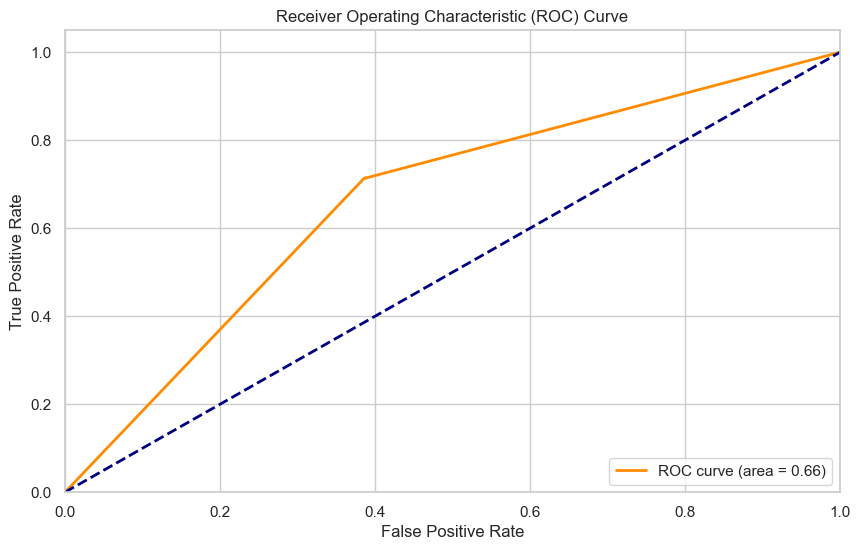

In [35]:
import pickle
nnmodel=pickle.load(open('./models/nnmodel.pkl','rb'))
y_prob = nnmodel.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
from sklearn.metrics import roc_curve, auc
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [60]:
print(ModelStats)

{'Random Forest': {'accuracy': 0.9875812229338093, 'error_rate': 0.012418777066190656, 'precision': 0.9900966988996333, 'recall': 0.9748834460568652, 'f1_score': 0.982431180518793, 'specificity': 0.9946056558880688, 'roc_auc': 0.9988774221299899}, 'Naive Bayes': {'accuracy': 0.5959434333669854, 'error_rate': 0.4040565666330146, 'precision': 0.46750031083093707, 'recall': 0.9670365749556766, 'f1_score': 0.6302938653665426, 'specificity': 0.3906540415201032, 'roc_auc': 0.6788437126790523}, 'Decision Tree': {'accuracy': 0.9872050735342842, 'error_rate': 0.012794926465715784, 'precision': 0.982109336091637, 'recall': 0.9819642349027076, 'f1_score': 0.982036780137303, 'specificity': 0.9901043148698637, 'roc_auc': 0.9860342748862857}, 'Logistic Regression': {'accuracy': 0.6025815932363271, 'error_rate': 0.3974184067636729, 'precision': 0.4676117635176701, 'recall': 0.8360529253398122, 'f1_score': 0.5997680019313545, 'specificity': 0.47342483335654134, 'roc_auc': 0.8053381917610289}, 'Neural 

In [62]:
for i in ModelStats:
    printStats(ModelStats[i],i)


Random Forest Performance Metrics:
------------------------------
Accuracy    : 0.9876
Error Rate  : 0.0124
Precision   : 0.9901
Recall      : 0.9749
F1 Score    : 0.9824
Specificity : 0.9946
ROC AUC     : 0.9989
------------------------------


Naive Bayes Performance Metrics:
------------------------------
Accuracy    : 0.5959
Error Rate  : 0.4041
Precision   : 0.4675
Recall      : 0.9670
F1 Score    : 0.6303
Specificity : 0.3907
ROC AUC     : 0.6788
------------------------------


Decision Tree Performance Metrics:
------------------------------
Accuracy    : 0.9872
Error Rate  : 0.0128
Precision   : 0.9821
Recall      : 0.9820
F1 Score    : 0.9820
Specificity : 0.9901
ROC AUC     : 0.9860
------------------------------


Logistic Regression Performance Metrics:
------------------------------
Accuracy    : 0.6026
Error Rate  : 0.3974
Precision   : 0.4676
Recall      : 0.8361
F1 Score    : 0.5998
Specificity : 0.4734
ROC AUC     : 0.8053
------------------------------


Neural Netw

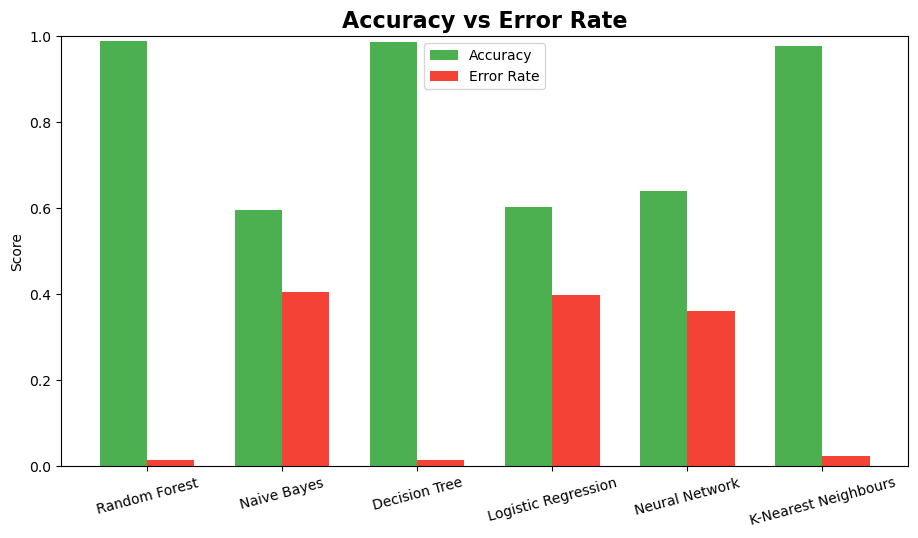

In [122]:
import matplotlib.pyplot as plt
import numpy as np
model_metrics = ModelStats
models = list(model_metrics.keys())
metrics_names = ['accuracy', 'precision', 'recall', 'f1_score', 'specificity', 'roc_auc']
metrics_values = {metric: [model_metrics[model][metric] for model in models] for metric in metrics_names}

fig = plt.figure(figsize=(18, 15))
ax1 = fig.add_subplot(321)
bar_width = 0.35
x = np.arange(len(models))
ax1.bar(x - bar_width/2, metrics_values['accuracy'], width=bar_width, label='Accuracy', color='#4CAF50')
ax1.bar(x + bar_width/2, [1 - acc for acc in metrics_values['accuracy']], width=bar_width, label='Error Rate', color='#F44336')
ax1.set_title('Accuracy vs Error Rate', fontsize=16, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15)
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)
ax1.legend()
plt.tight_layout()
plt.show()


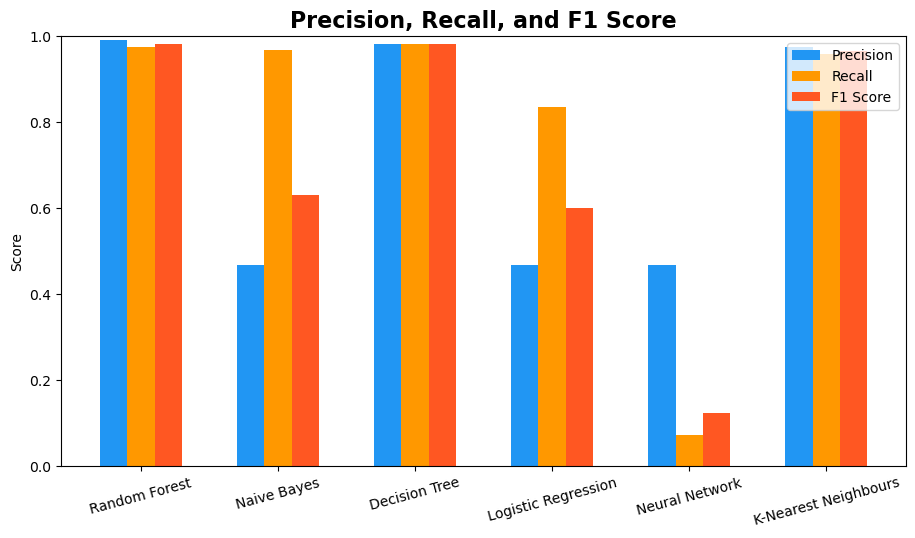

In [120]:
import matplotlib.pyplot as plt
import numpy as np
model_metrics = ModelStats
models = list(model_metrics.keys())
metrics_names = ['accuracy', 'precision', 'recall', 'f1_score', 'specificity', 'roc_auc']
metrics_values = {metric: [model_metrics[model][metric] for model in models] for metric in metrics_names}

fig = plt.figure(figsize=(18, 15))ax2 = fig.add_subplot(322)
bar_width = 0.2
x = np.arange(len(models))
ax2.bar(x - bar_width, metrics_values['precision'], width=bar_width, label='Precision', color='#2196F3')
ax2.bar(x, metrics_values['recall'], width=bar_width, label='Recall', color='#FF9800')
ax2.bar(x + bar_width, metrics_values['f1_score'], width=bar_width, label='F1 Score', color='#FF5722')
ax2.set_title('Precision, Recall, and F1 Score', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15)
ax2.set_ylabel('Score')
ax2.set_ylim(0, 1)
ax2.legend()
plt.tight_layout()
plt.show()

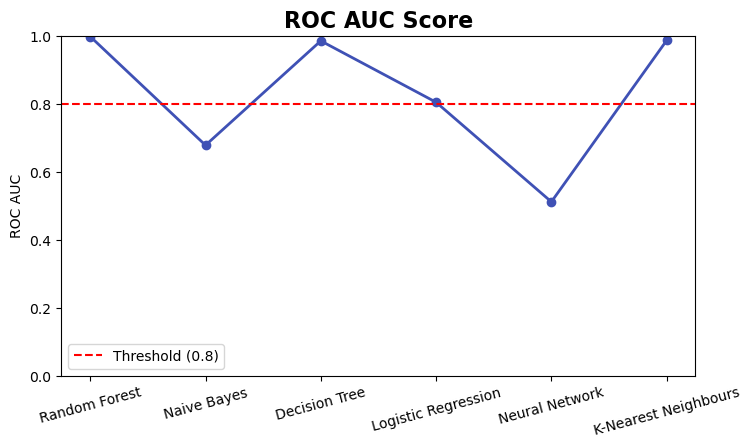

In [124]:
import matplotlib.pyplot as plt
import numpy as np
model_metrics = ModelStats
models = list(model_metrics.keys())
metrics_names = ['accuracy', 'precision', 'recall', 'f1_score', 'specificity', 'roc_auc']
metrics_values = {metric: [model_metrics[model][metric] for model in models] for metric in metrics_names}

fig = plt.figure(figsize=(18, 15))fig = plt.figure(figsize=(18, 15))
ax3 = fig.add_subplot(323)
ax3.plot(models, metrics_values['roc_auc'], marker='o', color='#3F51B5', linewidth=2)
ax3.set_title('ROC AUC Score', fontsize=16, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.axhline(y=0.8, color='r', linestyle='--', label='Threshold (0.8)')
ax3.set_ylabel('ROC AUC')
ax3.set_xticklabels(models, rotation=15)
ax3.legend()


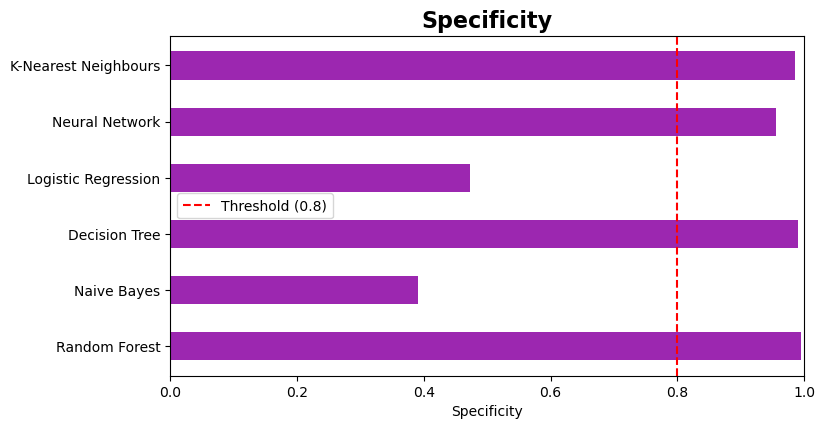

In [130]:
import matplotlib.pyplot as plt
import numpy as np
model_metrics = ModelStats
models = list(model_metrics.keys())
metrics_names = ['accuracy', 'precision', 'recall', 'f1_score', 'specificity', 'roc_auc']
metrics_values = {metric: [model_metrics[model][metric] for model in models] for metric in metrics_names}

fig = plt.figure(figsize=(18, 15))fig = plt.figure(figsize=(18, 15))
ax4 = fig.add_subplot(324)
y_pos = np.arange(len(models))
ax4.barh(y_pos, metrics_values['specificity'], color='#9C27B0', height=0.5)
ax4.set_yticks(y_pos)
ax4.set_yticklabels(models)
ax4.set_title('Specificity', fontsize=16, fontweight='bold')
ax4.set_xlim(0, 1)
ax4.set_xlabel('Specificity')
ax4.axvline(x=0.8, color='r', linestyle='--', label='Threshold (0.8)')
ax4.legend()